# Imports 

In [35]:
import numpy as np
import pandas as pd
import os
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

In [36]:
pd.set_option('max_rows', 96)


    The following is a regression analysis of the abs/fluo data that is used 
    to create the model that will deconvolve the signals
    

## Pre-Processing

In [37]:
file_loc = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data/abs-flu/exp1/tecan_results/abs-flu_exp1_parsed.tsv""" # local copy

In [38]:
df = pd.read_csv(file_loc, index_col=0)
df.head()

,Measurement_type,Wavelength,Row,Column,Measurement,Well,Sample,True_abs_C,True_abs_B,Blank_for_measurement,Measurement-Blank
0,Absorbance,680_nm,A,1,0.8037,A1,S01,0.25,0.200,0.0827,0.7210
1,Absorbance,680_nm,B,1,0.8649,B1,S13,0.25,0.175,0.0827,0.7822
2,Absorbance,680_nm,C,1,0.7752,C1,S25,0.25,0.150,0.0827,0.6925
3,Absorbance,680_nm,D,1,0.7808,D1,S37,0.25,0.125,0.0827,0.6981
4,Absorbance,680_nm,E,1,0.7615,E1,S49,0.25,0.100,0.0827,0.6788


In [39]:
df = df[["Measurement_type", "Wavelength", "Row", "Column",
         "Measurement", "True_abs_C", "True_abs_B",
         "Blank_for_measurement", "Measurement-Blank"]]

# to rename the columns
col_index = ['type','wavelen', 'row', 'col', 'measurement', 'chlamy_cnt',
         'bact_cnt','blank', 'corr_measurement']
df.columns = col_index

# changes to order of the columns
df = df.reindex(columns=['type', 'wavelen', 'row', 'col', 
                         'chlamy_cnt','bact_cnt', 'measurement',
                         'blank', 'corr_measurement'])


# there exists a parsing error:
# all 96-W.Plate's rows should have the same value for
# bacterial concentration but when viewed by row (A:H) 
# the last column where [chlamy]=0.0 it show's the
# following rows value: see 'B:12'
   

#df[(df['row']=='B') & (df['wavelen']=='680_nm')].head(12)


rows=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
wavelen = ['680_nm', '750_nm', 'Ex:440_nm/Em:680_nm']
for row in rows:
    for wl in wavelen:

        temp_df = df[(df['row']==row) & (df['wavelen']==wl)]
        #temp_df
        # idx of last row and value of 'bact_cnt' at previous row
        row12idx = temp_df.index[-1]
        prev_value = df[(df['row']==row) & (df['wavelen']==wl)].iloc[10,5]
        df.at[row12idx, 'bact_cnt'] = prev_value

In [40]:
df['col'] = df['col'].map(str)
df['well'] = df['row']+df['col']
wells = df['well'].values


df.head()

,type,wavelen,row,col,chlamy_cnt,bact_cnt,measurement,blank,corr_measurement,well
0,Absorbance,680_nm,A,1,0.25,0.200,0.8037,0.0827,0.7210,A1
1,Absorbance,680_nm,B,1,0.25,0.175,0.8649,0.0827,0.7822,B1
2,Absorbance,680_nm,C,1,0.25,0.150,0.7752,0.0827,0.6925,C1
3,Absorbance,680_nm,D,1,0.25,0.125,0.7808,0.0827,0.6981,D1
4,Absorbance,680_nm,E,1,0.25,0.100,0.7615,0.0827,0.6788,E1



    # each Well has three associated readings with it
        # Absorbance (nm)
            # 680
            # 750

        # Fluorescence
            # exitation @ 440 &  emission reading @ 680

### Absorbance @ 680

In [41]:
df_abs_680 = df.loc[(df['type']=='Absorbance') & (df['wavelen']=='680_nm')]
df_abs_680 = df_abs_680.rename(columns={'measurement':'abs_680','blank':'blank_680',
                                        'corr_measurement':'corr_abs_680'})

wells = df['well'].values

keep_cols = ['row', 'col', 'well', 'chlamy_cnt',  'bact_cnt', 'corr_abs_680']
new_idx = ['row', 'col', 'well', 'chlamy_cnt',  'bact_cnt']
df_abs_680 = df_abs_680[keep_cols].set_index(new_idx)
df_abs_680.sample(n=5)

,,,,,corr_abs_680
row,col,well,chlamy_cnt,bact_cnt,
G,3,G3,0.20,0.025,0.5094
H,12,H12,0.00,0.000,0.0000
C,1,C1,0.25,0.150,0.6925
G,5,G5,0.15,0.025,0.3598
F,5,F5,0.15,0.050,0.5010


### Absorbance @ 750

In [42]:
df_abs_750 = df.loc[(df['type']=='Absorbance') & (df['wavelen']=='750_nm')]
df_abs_750 = df_abs_750.rename(columns={'measurement':'abs_750','blank':'blank_750',
                                        'corr_measurement':'corr_abs_750'})

keep_cols = ['row', 'col', 'well', 'chlamy_cnt', 'bact_cnt', 'corr_abs_750']

df_abs_750 = df_abs_750[keep_cols].set_index(new_idx)

df_abs_750.sample(n=5)

,,,,,corr_abs_750
row,col,well,chlamy_cnt,bact_cnt,
E,1,E1,0.250,0.100,0.3414
B,12,B12,0.000,0.175,0.1970
G,11,G11,0.005,0.025,0.0230
F,12,F12,0.000,0.050,0.0418
G,8,G8,0.075,0.025,0.0951


### Fluorescence: Excitation @ 440 | Emission @680

In [43]:
df_fluo_680 = df.loc[df['type']=="Fluorescence Bottom Reading"]
df_fluo_680 = df_fluo_680.rename(columns={'measurement':'fluo_680', 'blank':'blank_fluo',
                                          'corr_measurement':'corr_fluo'})

df_fluo_680.loc[df_fluo_680['corr_fluo']==0]
# looking at the data of column=12 ---the experimental samples column
# where[chlamy] = 0: here there are some zero values which is expected
# however this presents a problem when log transforming the values as
# as log(0) returns an infinite value... 
# however the average uncorrected reading is 4.75 with the BLANK reading
# having a value of 3. The uncorrected mode is 4 (corrected mode = 1) 
# with all but 2 values NOT (3 or 4), therefore these values will be 
# changed to 1 to avoid the infinite errors coming from the log transform
# this should not affect the models 

df_fluo_680.loc[df_fluo_680['corr_fluo']==0, 'corr_fluo'] =1
df_fluo_680['ln(corr_fluo)'] = np.log(df_fluo_680['corr_fluo'])

keep_cols = ['row', 'col', 'well', 'chlamy_cnt', 'bact_cnt', 'corr_fluo', 'ln(corr_fluo)']
df_fluo_680 = df_fluo_680[keep_cols].set_index(new_idx)

df_fluo_680.sample(n=5)


,type,wavelen,row,col,chlamy_cnt,bact_cnt,fluo_680,blank_fluo,corr_fluo,well
283,Fluorescence Bottom Reading,Ex:440_nm/Em:680_nm,D,12,0.0,0.125,3.0,3.0,0.0,D12
287,Fluorescence Bottom Reading,Ex:440_nm/Em:680_nm,H,12,0.0,0.000,3.0,3.0,0.0,H12


,,,,,corr_fluo,ln(corr_fluo)
row,col,well,chlamy_cnt,bact_cnt,,
G,7,G7,0.100,0.025,4240.0,8.352319
A,4,A4,0.175,0.200,3409.0,8.134174
F,4,F4,0.175,0.050,5229.0,8.561975
A,6,A6,0.125,0.200,2955.0,7.991254
C,9,C9,0.050,0.150,2021.0,7.611348


## Absorbance @ 600 

In [44]:
data_folder = '/home/rdmtinez/Desktop/MScThesis/data/abs-flu/exp1/tecan_results/'
file =  'a600.csv'
filepath = os.path.join(data_folder,file)

a600 = pd.read_csv(filepath)
a600 = a600.set_index('well')
a600['average'] = a600.loc['H12'][0]

a600['corr_abs_600'] = a600['A600'] - a600['average']

a600 = a600[['corr_abs_600']]


df_abs_600 = df.loc[(df['type']=='Absorbance') & (df['wavelen']=='680_nm')]
df_abs_600 = df_abs_600[['row', 'col', 'well', 'chlamy_cnt', 'bact_cnt']]
df_abs_600 = df_abs_600.set_index('well')
df_abs_600 = pd.concat([df_abs_600, a600], join='outer', axis=1, sort=False)
df_abs_600 = df_abs_600.reset_index().rename({'index':'well'}, axis=1)
df_abs_600 = df_abs_600.set_index(new_idx)


In [45]:
df_abs_600.head()

,,,,,corr_abs_600
row,col,well,chlamy_cnt,bact_cnt,
A,1,A1,0.25,0.200,0.5370
B,1,B1,0.25,0.175,0.5559
C,1,C1,0.25,0.150,0.5014
D,1,D1,0.25,0.125,0.4693
E,1,E1,0.25,0.100,0.4531


# Main DataFrame

In [46]:
####### concatenation of the previous dataframes
df_main = pd.concat([df_abs_600, df_abs_680, df_abs_750, df_fluo_680], axis = 1)


df_main = df_main.reset_index()

In [47]:
#df_main.loc[df_main['chlamy_cnt']==0, 'chlamy_cnt'] = 0.001
#df_main.loc[df_main['bact_cnt']==0, 'bact_cnt'] = 0.001

In [48]:
df_main['ln(chlamy_cnt)'] = np.log(df_main['chlamy_cnt'])
df_main['ln(bact_cnt)'] = np.log(df_main['bact_cnt'])

/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [49]:
df_main = df_main[['row', 'col', 'well', 'chlamy_cnt', 'ln(chlamy_cnt)',
                   'bact_cnt', 'ln(bact_cnt)', 'corr_abs_600', 'corr_abs_680', 
                   'corr_abs_750', 'corr_fluo', 'ln(corr_fluo)']]

In [50]:
#df_main['corr_abs_680'].sort_values()
#df_main['corr_abs_750'].sort_values()

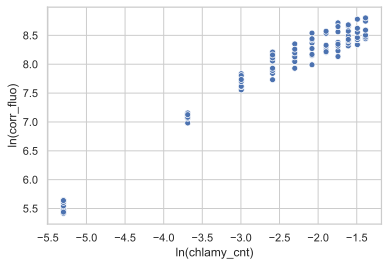

In [51]:
sns.scatterplot(x='ln(chlamy_cnt)', y='ln(corr_fluo)', data=df_main)

### Export Main_DF

In [52]:
# dirname="/home/rdmtinez/Desktop/MScThesis/data/abs-flu/exp1/tecan_results/"
# fname='abs-fluo_exp1_main.csv'
# df_main.to_csv(dirname+fname)

# Curve Fitting Functions

    These are simple linear regression models which will first be fitted
    and then used to predict the absorbance values

In [53]:
# linear curve
def linear_curve(parameters, xdata):
    """
    A680 & A750 show a linear relationship:
    y = m*x + b
    
    m = slope
    b = y-intercept
    """
    m = parameters[0]
    b = parameters[1]
    
    return m*xdata + b


def linear_curve_residuals(parameters, xdata, ydata, function):
    """
    xdata = [chlamy] or [bacter]
    
    ydata = observed A680 or A750
    
    Computes the residuals of y_pred -y_obs, where:
        y_pred = line(parameters, xdata)
    """
    
    return linear_curve(parameters,xdata) - ydata


def root_curve(parameters, xdata):
    """
    F680 shows an obvious root-function relationship:
    
    y = a√(b*x)
    
    'a' and 'b' control area under the curve with
    'b' doing so much more slowly
    
    NOTE: 
        
        the following permutations of this model were
        also made :
            y = √(b*x)
            y = a√(x)
        
        however these mono-parameter models produce large
        coefficients thus the best model to use is below:
            y = a√(b*x)
    
    """
    
    a = parameters[0]
    b = parameters[1]
    
    return a*np.sqrt(b*xdata)


def root_curve_residuals(parameters, xdata, ydata, function):
    """
    xdata = [chlamy] or [bacter]
    
    ydata = observed F680
    
    Computes the residuals of y_pred - y_obs, where
    y_pred = root_curve(parameters, xdata)
    
    """
    
    return root_curve(parameters, xdata) - ydata

In [54]:
chlamy_cnt = df_main['chlamy_cnt'].unique()


rows=df_main['row'].unique()


In [55]:
#extraction of operable data


# xdata = [chlamy] or [bacter]
chlamy_cnt = df_main['chlamy_cnt'].unique()
rows = df_main['row'].unique()
# store absorbance values that will be plotted on one figure   B
corr_abs_600 = []
corr_abs_680 = []
corr_abs_750 = []
corr_flu_680 = []
log_corr_flu = []
for row in rows:
    
    #append the values to their respective list
    corr_abs_600.append(df_main.loc[df_main['row']==row, 'corr_abs_600'].to_list())
    corr_abs_680.append(df_main.loc[df_main['row']==row, 'corr_abs_680'].to_list())
    corr_abs_750.append(df_main.loc[df_main['row']==row, 'corr_abs_750'].to_list())
    corr_flu_680.append(df_main.loc[df_main['row']==row, 'corr_fluo'].to_list())
    log_corr_flu.append(df_main.loc[df_main['row']==row, 'ln(corr_fluo)'].to_list())


bacter_cnt = df_main['bact_cnt'].unique()
cols = df_main['col'].unique()

# store fluorescence values
corr_abs_600_col = []
corr_abs_750_col = []
corr_abs_680_col = []
corr_flu_680_col = []
log_corr_flu_col = []
for col in cols:
    
    # append
    corr_abs_600_col.append(df_main.loc[df_main['col']==col, 'corr_abs_600'].to_list())
    corr_abs_680_col.append(df_main.loc[df_main['col']==col, 'corr_abs_680'].to_list())
    corr_abs_750_col.append(df_main.loc[df_main['col']==col, 'corr_abs_750'].to_list())
    corr_flu_680_col.append(df_main.loc[df_main['col']==col, 'corr_fluo'].to_list())
    log_corr_flu_col.append(df_main.loc[df_main['row']==row, 'ln(corr_fluo)'].to_list())
    

## Parameter Fitting

In [56]:
# Note: For a given row (e.g. 'A'), the constant is a [bacter] 
#       For a given col (e.g. '1'), the constant is a [chlamy]

params_A600_B = []
x0=[0,0]
for ydata in corr_abs_600:
    optimize_result = scipy.optimize.least_squares(linear_curve_residuals, x0, 
                                               args = (chlamy_cnt, ydata,
                                                      linear_curve))
    params_A600_B.append(optimize_result.x)
    
    
    
params_A600_C = []
x0=[0,0]
for ydata in corr_abs_600_col:
    optimize_result = scipy.optimize.least_squares(linear_curve_residuals, x0, 
                                               args = (bacter_cnt, ydata,
                                                      linear_curve))
    params_A600_C.append(optimize_result.x)
    
    
params_A680_B = []
x0=[0,0]
for ydata in corr_abs_680:
    optimize_result = scipy.optimize.least_squares(linear_curve_residuals, x0, 
                                               args = (chlamy_cnt, ydata,
                                                      linear_curve))

    params_A680_B.append(optimize_result.x)

    
    
params_A680_C = []
x0=[0,0]
for ydata in corr_abs_680_col:
    optimize_result = scipy.optimize.least_squares(linear_curve_residuals, x0, 
                                               args = (bacter_cnt, ydata,
                                                      linear_curve))

    params_A680_C.append(optimize_result.x)
    
    
    
params_A750_B = []
x0=[0,0]
for ydata in corr_abs_750:
    optimize_result = scipy.optimize.least_squares(linear_curve_residuals, x0, 
                                               args = (chlamy_cnt, ydata,
                                                      linear_curve))

    params_A750_B.append(optimize_result.x)
       

params_A750_C = []
x0=[0,0]
for ydata in corr_abs_750_col:
    optimize_result = scipy.optimize.least_squares(linear_curve_residuals, x0, 
                                               args = (bacter_cnt, ydata,
                                                      linear_curve))

    params_A750_C.append(optimize_result.x)


params_F680 = []
x0 = [1,1]
for ydata in corr_flu_680:
    optimize_result = scipy.optimize.least_squares(root_curve_residuals, x0,
                                                   args=(chlamy_cnt, ydata, root_curve))

    params_F680.append(optimize_result.x)
    

/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in sqrt


# Data Viz

## Absorbance
    
        
    Absorbance = -log(Transmission= I/Io) 
    Io = amount of light that makes to the cuvette
    I  = amount of light that makes past the cuvette and onto the detector
    the more of a substance there is in the cuvette the more is absorbed

    
#### 96-W.Plates | Rows

<Figure size 576x792 with 0 Axes>

(-0.02, 1.0)

Text(0.5, 0, '[chlamy]')

(-0.02, 1.0)

Text(0.5, 0, '[chlamy]')

(-0.02, 1.0)

Text(0.5, 0, '[chlamy]')

(-0.02, 1.0)

Text(0.5, 0, '[chlamy]')

(-0.02, 1.0)

Text(0.5, 0, '[chlamy]')

(-0.02, 1.0)

Text(0.5, 0, '[chlamy]')

(-0.02, 1.0)

Text(0.5, 0, '[chlamy]')

(-0.02, 1.0)

Text(0.5, 0, '[chlamy]')

Text(0.5, 1.02, 'Absorbances @ Constant [bacter]')

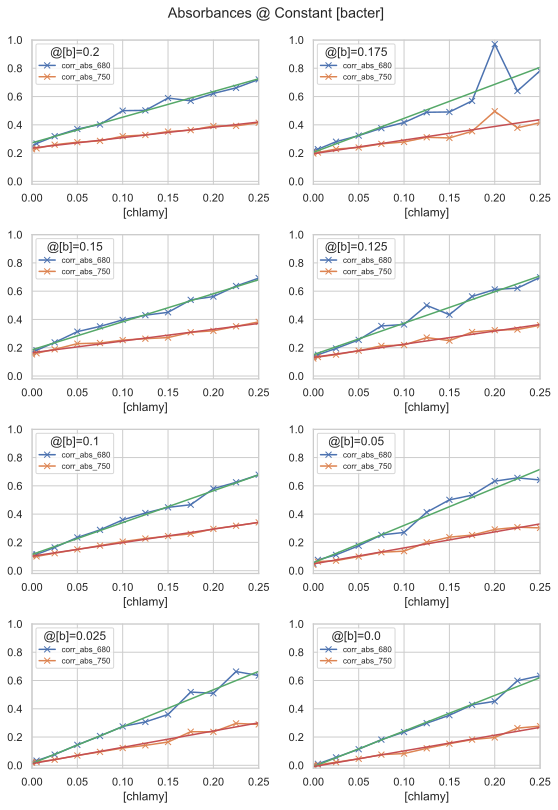

In [61]:
# Note: row=='H' has only Chlamy in the well and no bacteria
plt.figure(figsize=(8,11))
gs = gridspec.GridSpec(4,2)
axes = []
for r in [0,1,2,3]:
    for c in [0,1]:
        axes.append(plt.subplot(gs[r,c]))
        
# concentrations as standard python lists
chlamy_cnt_lst = df_main.loc[df_main['row']=='A']['chlamy_cnt'].to_list()
bacter_cnt_lst = df_main.loc[df_main['col']=='1']['bact_cnt'].to_list()


# axes acces through generator
axes = (ax for ax in axes)
rows=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

ymin=-0.02
ymax=1.0

xmock = np.linspace(0, .25, 100)
i = 0
for row in rows:
    
    
    ax=next(axes)
    ax.set_ylim(ymin,ymax)
    df_main.loc[df_main['row']==row].plot(x='chlamy_cnt', y=['corr_abs_680', 'corr_abs_750'],
                                          style='-x', ax=ax)
                                         
    
    ax.set_xlabel('[chlamy]')
    ax.legend(loc=2, title='@'+'[b]='+str(bacter_cnt_lst[i]), prop={'size': 8})
    ax.plot(xmock, linear_curve(params_A680_B[i], xmock))
    ax.plot(xmock, linear_curve(params_A750_B[i], xmock))
    
    i+=1
plt.tight_layout()
plt.suptitle('Absorbances @ Constant [bacter]', y=1.02)
plt.savefig('Absorbances_B.pdf')
    
    
# Observations:

# as expected the contribution to the A680 signal from the bacteria
# is minimal, this is evidenced by the fact that those absorbance readings
# remain very similar even as the [bacter] changes significantly
# ---its a good way to measure chlamy growth for sure

# Unfortunately there is still chlamy contribution to the A750 signal as
# these are not as steady as we had expected. Note that for each plot here 
# [bacter] is held constant and we're hoping to measure mostly [bacter] at 
# 750 then those measurements should be fairly parallel, but they increase
# with incrasing [chlamy] in every plot

# Fortunately, the slope of the A750 measurement seems to be very constant
# across the board, meaning that there is a certain amount of contribution
# that increasing [chlamy] has on that signal

# ---------------------------M = slope of curve---------------------------
#
# plot: 750_Mi v. [bacter]
# plot: 680_Mi v. [bacter]
#
# - I expect that the each plot's slope for a given wavelen
# - is equivalent to all others M1=M2=...=Mn


# ---------------------------A = area between curves----------------------
# plot: Ai v. [bacter]  | Ai = A_680 - A_750
#
# - I expect that the areas are also all equivalent A1=A2=...=Mn
# ------------------------------------------------------------------------

#### 96W.Plates | Columns

<Figure size 576x1152 with 0 Axes>

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

(-0.02, 1.0)

Text(0.5, 0, '[bacter]')

Text(0.5, 1.02, 'Absorbances @ Consant [chlamy]')

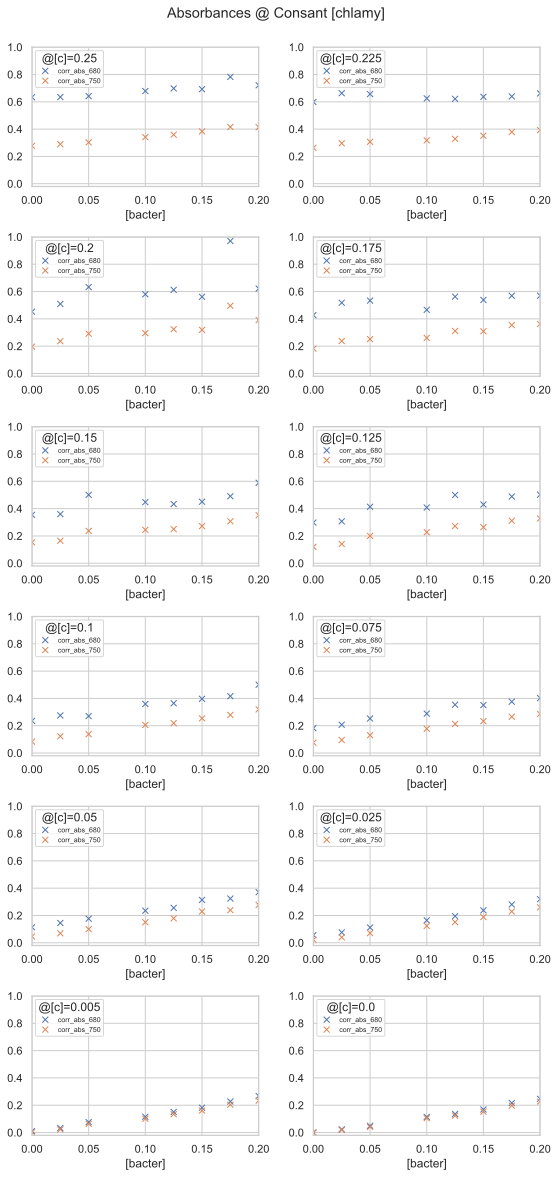

In [65]:
# Note: col='12' has only Bacteria in the well and no chlamy
df_main['col'] = df_main['col'].map(int)

plt.figure(figsize=(8,16))
gs = gridspec.GridSpec(6,2)
axes = []
for r in [0,1,2,3,4,5]:
    for c in [0,1]:
        axes.append(plt.subplot(gs[r,c]))        

# as a generator
axes = (ax for ax in axes)

cols=[n for n in range(1,13)]
i=0
for col in cols:
    
    ax=next(axes)
    ax.set_ylim(ymin,ymax)
    fig = df_main.loc[df_main['col']==col].plot(x='bact_cnt', y=['corr_abs_680', 'corr_abs_750'],
                                           style='x', ax=ax)
    
    ax.set_xlabel('[bacter]')
    ax.legend(loc=2, title='@'+'[c]='+str(chlamy_cnt_lst[i]), prop={'size': 7})
    #ax.plot(xmock, linear_curve(params_A680_C[i], xmock))
    #ax.plot(xmock, linear_curve(params_A750_C[i],xmock))
    i+=1
    
plt.tight_layout()
plt.suptitle('Absorbances @ Consant [chlamy]', y=1.02)
plt.savefig('Absorbances_C.pdf')

# Observations:

# A680 heavily influenced by [chlamy] as is expected
# the upper [chlamy] concentrations (.250, .225) almost completely                    
# obscure the contribution of the bacteria tothe A680 signal, one can deduce
# this from the fact that the signal is fairly parallel to the x-axis as
# would be expected given the constant concentration of chlamy . . . 

# howver, as the [chalmy] concentration decrease so too does the overall signal
# and the tendency for M_680 to be parallel to x-axis diminishes, instead the 
# signal begins to behave much like the A750 singal and both assume the same slope
# this means that a low [chlamy] much of the measured signal is coming from
# absorbance due to [bacteria] ... 


# a rather more interesting observation is the A750 signal, recall that we use this
# wavelen to capture mainly the contribution of bacteria, we can observe that indeed
# the contribution is measuring the [bacteria] but the overall amplitude is modulated
# by the presence of chlamydomonas

# ---------------------------M = slope of curve---------------------------
# plot: 750_Mi v. [chlamy]
#
# - I expect that the each plot's slope is
# - equivalent to all others M1=M2=...=Mn = M_ave
#
# plot: d[Mi] vs [chlamy] & d|y-int| vs [chlamy]
# - I expected that amplitude of the A750 curve
# - is linearly dependent on [chlamy], both the
# - d[Mi] & d|y-int| should equal


## Fluorescence
#### 96-W.Plates | Rows

<Figure size 576x792 with 0 Axes>

(-100, 7000)

Text(0.5, 0, '[chlamy]')

(-100, 7000)

Text(0.5, 0, '[chlamy]')

(-100, 7000)

Text(0.5, 0, '[chlamy]')

(-100, 7000)

Text(0.5, 0, '[chlamy]')

(-100, 7000)

Text(0.5, 0, '[chlamy]')

(-100, 7000)

Text(0.5, 0, '[chlamy]')

(-100, 7000)

Text(0.5, 0, '[chlamy]')

(-100, 7000)

Text(0.5, 0, '[chlamy]')

Text(0.5, 1.03, 'Fluorescences @ Constant [bacter]')

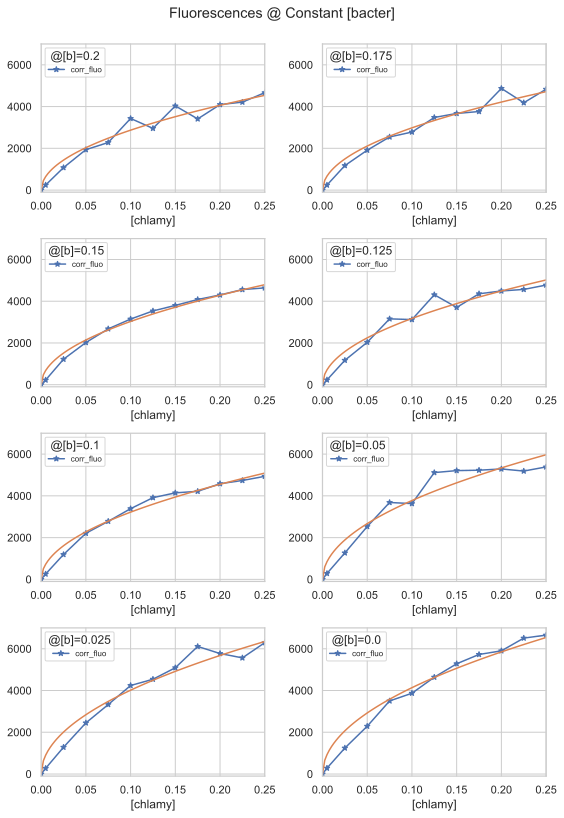

In [59]:
# Note: row=='H' has only Chlamy in the well and no bacteria
plt.figure(figsize=(8,11))
gs = gridspec.GridSpec(4,2)
axes = []
for r in [0,1,2,3]:
    for c in [0,1]:
        axes.append(plt.subplot(gs[r,c]))

# as a generator
axes = (ax for ax in axes)

#x-values for the fitted line
xmock = np.linspace(0, .25, 100)
rows=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
i = 0
for row in rows:

    ax = next(axes)
    ax.set_ylim(-100, 7000)
    df_main.loc[df_main['row']==row].plot(x='chlamy_cnt', y='corr_fluo',
                                           style='-*', ax=ax)
    ax.set_xlabel('[chlamy]')
    
    ax.legend(loc=2, title='@'+'[b]='+str(bacter_cnt_lst[i]), prop={'size': 8})
    ax.plot(xmock, root_curve(params_F680[i], xmock))
    i+=1
    
plt.tight_layout()
plt.suptitle('Fluorescences @ Constant [bacter]', y=1.03)
plt.savefig('Fluorescence_B.pdf')

#xmock = np.linspace(0, .25, 25)
#for ab in param_a_b_F680:
    #ax = next(axes_)
    #ax.plot(xmock, root_curve(ab,xmock))
    
# Observations:

# there is an obvious exponential relationship between F680 v. [chlamy], and its
# also obvious that the signal is dampened by the increasing [bacter], this means
# that bacteria absorb some of the emitted F680 light... we can try and determine
# how much light is captured by bacteria by plotting the following: 

# ---------------------------A = area under curves----------------------
# plot: Ai v. [bacter] 
# - I expect that the areas show this (-)linear dependency
# ------------------------------------------------------------------------

#### 96-W.Plates | Cols

<Figure size 792x1008 with 0 Axes>

(-100, 7000)

TypeError: Empty 'DataFrame': no numeric data to plot

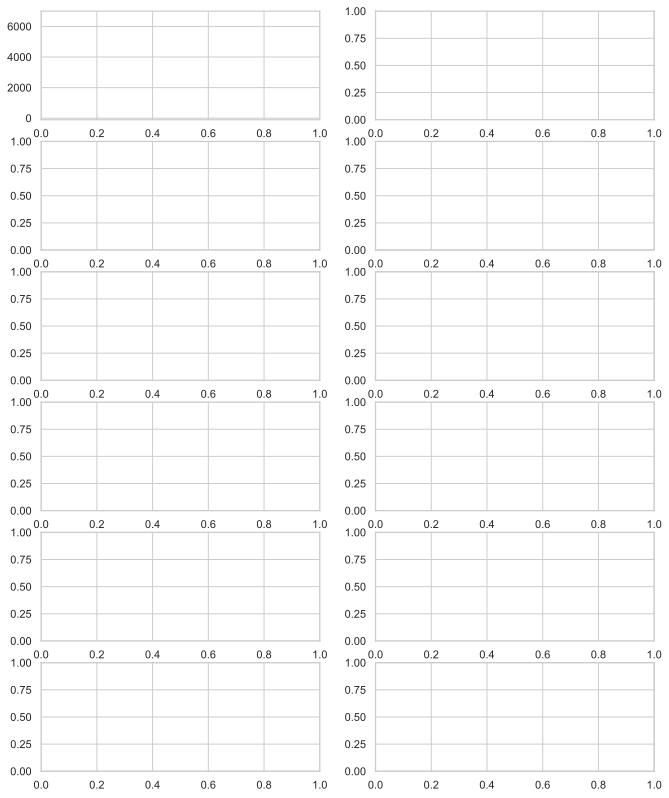

In [60]:
# Note: col='12' has only Bacteria in the well and no chlamy
df_main['col'] = df_main['col'].map(str)

plt.figure(figsize=(11,14))
gs = gridspec.GridSpec(6,2)
axes = []
for r in [0,1,2,3,4,5]:
    for c in [0,1]:
        axes.append(plt.subplot(gs[r,c]))        

# as a generator
axes = (ax for ax in axes)

cols=[n for n in range(1,13)]
for col in cols:
    
    chlamy_cnt = df_main.loc[df_main['col']==col]['chlamy_cnt'].reset_index(drop=True)
    ax=next(axes)
    ax.set_ylim(-100,7000)
    fig = df_main.loc[df['col']==col].plot(x='bact_cnt', y=['corr_fluo'],
                                           style='-*', ax=ax)
    
    ax.set_xlabel('[bacter]')
    ax.legend(loc=0, title='@'+'[c]='+str(chlamy_cnt_lst[i]), prop={'size': 8})
    
plt.tight_layout()
plt.suptitle('Fluorescences @ Constant [chlamy]', y=1.03)
plt.savefig('Fluorescence_C.pdf')

# Observations:

# as the [bacter] increases the fluorescence signal tends to decrease
# likely due to the bacteria absorbing F680

# this plot doesn't strike as being very useful, much like the Column's A680
# measurements